# Exercise 1

**a)** (Code: 7 points) Write a program to integrate the cross section numerically using
  Monte-Carlo event generation, for the case that the beam energies are fixed such that
  $s = M_Z^2$ , i.e. $f(s) = \delta(s − M_Z^2)$. Note that you can apply the averaging over
  outgoing quark flavours q by just picking a random flavour for each Monte-Carlo point.

The leading-order calculation for the e + e − → qq̄ matrix element yields the following
result:

$$
\begin{align*}
|M_{q\overline{q}} (s, \cos \theta, \phi)|^2
= 
(4\pi \alpha)^2 N_C  \left[
    \left(1 + \cos^2 \theta\right)
        \left\{
            Q^2_e Q^2_q + 2 Q_e Q_q V_e V_q \chi_1 (s) \\
            + \left(A^2_e + V_e^2\right) \left(A_q^2 + V_q^2\right) \chi_2 (s)
        \right\}\\
    + \cos \theta
        \left\{
            4 Q_e Q_q A_e A_q \chi_1 (s) + 8A_e V_e A_q V_q \chi_2 (s)
        \right\}
    \right]
\end{align*}
$$

where
 - $s = E_{CMS}^2$ is the centre-of-mass energy
 - $\theta$ the angle between the incoming positron and outgoing quark
 - $\alpha$ the QED coupling strength (fine structure constant)
 - $N_C$ the number of colour charges the quarks can carry
 - $Q_f$ the (electric?) charge of the particle $f$
 - $V_f = T_f^3 - 2 Q_f \sin^2(\theta_W)$ with $\theta_W$ the Weinberg angle is the vector coupling with 
 - $A_f = T_f^3$ is the axial coupling
 - $\chi_1(s) = \kappa \frac{s(s-M_Z^2)}{(s-M_Z^2)^2 + \Gamma_Z^2 M_Z^2}$
     - with $\kappa = \frac{1}{4 \sin^2(\theta_W) (1-\sin^2(\theta_W))}$
 - $\chi_2(s) = \kappa^2 \frac{s^2}{(s-M_Z^2)^2 + \Gamma_Z^2 M_Z^2}$
     - with $\kappa = \frac{1}{4 \sin^2(\theta_W) (1-\sin^2(\theta_W))}$

In [1]:
from integrator import *
from crosssection import *
from plotsettings import *

import numpy as np 
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp
import vegas

In [2]:
N_try = 100000

## Visualizing the integrand

In [3]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [4]:
def func(x, q):
    "throwaway function to plot the integrand"
    mel = eeqq_matrix_element(x[0], x[1], 0., q)
    return 0.5 * mel / x[0]

In [6]:
# generating the data for the plot
s = np.linspace((const.M_Z - 5*const.Gamma_Z)**2, (const.M_Z + 5*const.Gamma_Z)**2, 50)
costheta = np.linspace(-1, 1, 50)
x, y = np.meshgrid(s, costheta)
fu = func([x, y], "u") 
fc = func([x, y], "c") 
fd = func([x, y], "d") 
fs = func([x, y], "s") 
fb = func([x, y], "b") 

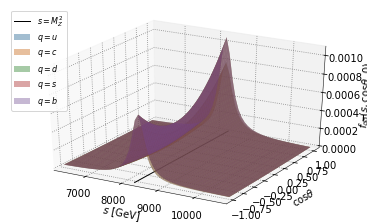

In [10]:
# and generating the plot
fig = plt.figure(figsize=figsize(0.9))
ax = fig.add_subplot(111, projection='3d')

for (f, q) in zip((fu, fc, fd, fs, fb), ("u", "c", "d", "s", "b")):
    surf = ax.plot_surface(x, y, f, alpha=0.4,
                       label=r"$q=" + q + "$")
    surf._facecolors2d=surf._facecolors3d
    surf._edgecolors2d=surf._edgecolors3d
    
ax.set_xlabel(r"$s~[\mathrm{GeV}]$")
ax.set_ylabel(r"$\cos \theta$")
ax.set_zlabel(r"$f_{q\overline{q}}(s, \cos \theta, 0)$")
ax.set_xlim((const.M_Z-5*const.Gamma_Z)**2, (const.M_Z+5*const.Gamma_Z)**2)
ax.plot((const.M_Z**2, const.M_Z**2), (-1.1, 1.1), (0, 0), color="k", label=r"$s=M_Z^2$")
ax.set_ylim(-1.1, 1.1)
ax.legend(loc=2)

fig.tight_layout()
fig.savefig("integrand.pgf")

# Exercise 1.a

In [27]:
domain = [(-1,1)]  # only costheta integration
codomain = (0, 30) # using integrator.samples this seemed to be a good
                   # choice
integrator = MCIntegrator.uniform(
    lambda x: eeqq_mel_random_q(const.M_Z**2, x, 0.), domain, codomain)

In [28]:
I = integrator(N_try)

In [29]:
mel = (I * const.N_q * 2 * np.pi * const.f_conv
        / (64 * np.pi**2 * const.M_Z**2))
print(f"σ(s=M_z²) = {mel} pb")

σ(s=M_z²) = (4.30+/-0.06)e+04 pb


In [30]:
print(f"sampling efficiency: {integrator.N_acc / integrator.N_try}")

sampling efficiency: 0.3076


In [12]:
# generating data for the log-log plot of the monte carlo error estimates
N_trys = np.logspace(1, 4, 100)
N_trys = np.floor(N_trys)
N_trys = N_trys.astype(int)
N_trys
variances_s_const = np.empty(100)
integrator.reset()
for (i, N_try) in enumerate(N_trys):
    integrator(N_try)
    s = (integrator.I * const.N_q * 2 * np.pi * const.f_conv
         / (64 * np.pi**2 * const.M_Z**2))
    variances_s_const[i] = s.std_dev

## Sampling uniformly in $s$

In [59]:
domain = [((const.M_Z-3*const.Gamma_Z)**2, (const.M_Z+3*const.Gamma_Z)**2),
          (-1,1)]
codomain = (0, 5e-7)
def func(x):
    "throwaway function that we will integrate"
    mel = eeqq_mel_random_q(x[0], x[1], 0.)
    mel /= domain[0][1] - domain[0][0]
    return 0.5 * mel / x[0]

integrator = MCIntegrator.uniform(func, domain, codomain, histograms=True, histbins=50)

In [60]:
I = integrator(10 * N_try)

In [61]:
mel = I * const.N_q * 2 * np.pi * const.f_conv / (32 * np.pi**2)
print(f"σ(s∈[(M_Z-3Γ_z)^2, (M_Z+3Γ_z)^2]) = {mel} pb")

σ(s∈[(M_Z-3Γ_z)^2, (M_Z+3Γ_z)^2]) = (9.95+/-0.10)e+03 pb


In [62]:
print(f"sampling efficiency: {integrator.N_acc / integrator.N_try}")

sampling efficiency: 0.09385


In [63]:
# generating data for the log-log plot of the monte carlo error estimates
N_trys = np.logspace(1, 4, 100)
N_trys = np.floor(N_trys)
N_trys = N_trys.astype(int)
N_trys
variances_s_uniform = np.empty(100)
integrator.reset()
for (i, N_try) in enumerate(N_trys):
    integrator(N_try)
    s = integrator.I * const.N_q * 2 * np.pi * const.f_conv / (32 * np.pi**2)
    variances_s_uniform[i] = s.std_dev

## $s$-Scanning

In [17]:
n_slices = 50
s_domain = np.linspace((const.M_Z-3*const.Gamma_Z)**2, (const.M_Z+3*const.Gamma_Z)**2,
                       n_slices)
slices = unp.uarray([0.] * n_slices, [0.] * n_slices)

In [18]:
domain = [(-1,1)]
codomain = (0, 30)
for (i, s) in enumerate(s_domain):
    integ = MCIntegrator.uniform(
                    lambda x : eeqq_mel_random_q(s, x, 0.),
                    domain, codomain)
    I = integ(10000)
    slices[i] = (I * const.N_q * 2 * np.pi * const.f_conv
                 / (64 * np.pi**2 * s))

In [19]:
slices /= np.sum(unp.nominal_values(slices)) * (s_domain[-1] - s_domain[1]) / (n_slices)

In [20]:
# and plotting acceptance probabilities together with the integral slices
x = np.linspace(7000, 9700, 100)
y = breit_wigner_pdf(x)
y /= np.sum(y) * (s_domain[-1] - s_domain[1]) / 99

fig, ax = plt.subplots(figsize=figsize(0.8))
integrator.histograms[0].Plot(ax=ax, c="C0", label=r"$p_{acc}(s)$")
ax.step(s_domain, unp.nominal_values(slices), c="C1",
        label=r"$\propto \int \, f(s, \cos \, \theta, 0) \, \mathrm{d}\cos \, \theta$")


ax.plot(x, 1.3 * y, label=r"$\propto \left[(s-M_Z^2)^2 + M_Z^2 \Gamma_Z^2\right]^{-1}$",
        color="gray")
ax.legend(loc=1)
ax.set_xlabel(r"$s ~[\mathrm{GeV}]$")
fig.tight_layout()
fig.savefig("histograms.pgf")

## Monte Carlo Error plots

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


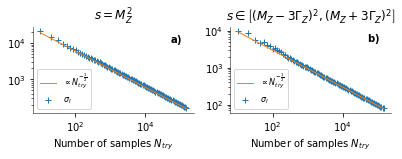

In [21]:
fig, ax = plt.subplots(1, 2, figsize=figsize(1., 0.4))
ax[0].plot(np.cumsum(N_trys), 6e4 / np.sqrt(np.cumsum(N_trys)),
        c="C1", label=r"$\propto N_{try}^{- \frac{1}{2}}$")
ax[0].scatter(np.cumsum(N_trys), variances_s_const,
              label=r"$\sigma_I$", marker="+")
ax[0].legend(loc=3)
ax[0].set_xlabel(r"Number of samples $N_{try}$")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].annotate(r"$\mathbf{a)}$", (50000, 10000))
ax[0].set_title(r"$s = M_Z^2$")

ax[1].plot(np.cumsum(N_trys), 3e4/np.sqrt(np.cumsum(N_trys)),
        c="C1", label=r"$\propto N_{try}^{- \frac{1}{2}}$")
ax[1].scatter(np.cumsum(N_trys), variances_s_uniform,
              label=r"$\sigma_I$", marker="+")
ax[1].legend(loc=3)
ax[1].set_xlabel(r"Number of samples $N_{try}$")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].annotate(r"$\mathbf{b)}$", (50000, 5000))
ax[1].set_title(r"$s \in \left[(M_Z - 3 \Gamma_Z)^2, (M_Z + 3 \Gamma_Z)^2\right]$")
fig.tight_layout()
fig.savefig("monte_carlo_errors.pgf")

## What happens in Vegas, stays in Vegas

In [64]:
domain = [((const.M_Z-3*const.Gamma_Z)**2, (const.M_Z+3*const.Gamma_Z)**2), (-1,1)]
codomain = (0, 5e-7)

def func(x):
    "yet another throwaway function to integrate over"
    mel = eeqq_mel_random_q(x[0], x[1], 0.)
    mel /= domain[0][1] - domain[0][0]
    return 0.5 * mel / x[0]

In [65]:
integ = vegas.Integrator(domain)
I = integ(func, nitn=10, neval=1000)

In [66]:
mel = I * const.N_q * 2 * np.pi * const.f_conv / (32 * np.pi**2)
print(f"with vegas: σ(s∈[(M_Z-3Γ_z)^2, (M_Z+3Γ_z)^2]) = {mel} pb")

with vegas: σ(s∈[(M_Z-3Γ_z)^2, (M_Z+3Γ_z)^2]) = 9917(20) pb


In [67]:
print(I.summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0002577(35)   0.0002577(35)       0.00     1.00
  2   0.0002581(24)   0.0002580(20)       0.01     0.91
  3   0.0002591(18)   0.0002586(13)       0.09     0.91
  4   0.0002562(16)   0.0002577(10)       0.49     0.69
  5   0.0002577(17)   0.00025766(87)      0.37     0.83
  6   0.0002528(16)   0.00025650(76)      1.77     0.12
  7   0.0002532(15)   0.00025579(68)      2.17     0.04
  8   0.0002564(14)   0.00025591(61)      1.88     0.07
  9   0.0002565(15)   0.00025600(56)      1.66     0.10
 10   0.0002562(14)   0.00025603(52)      1.48     0.15



In [58]:
# Plotting the vegas grid
vlines, hlines = integ.map.grid.base[0], integ.map.grid.base[1]
fig, ax = plt.subplots(figsize=figsize(0.7))
ax.hlines(hlines[::2], min(vlines), max(vlines))
ax.vlines(vlines[::3], min(hlines), max(hlines))
ax.set_xlabel(r"$s$")
ax.set_ylabel(r"$\cos (\theta)$")
for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.axvline(const.M_Z**2, -1, 1, color="C1", lw=2)    

ax.set_ylim(min(hlines), max(hlines))
ax.set_xlim(min(vlines), max(vlines))
ax.tick_params(axis=u"both", which=u"both", length=0)
fig.tight_layout()
fig.savefig("vegas_grid.pgf")

## Importance sampling

In [72]:
def func(x):
    "you know what this is..."
    mel = eeqq_mel_random_q(x[0], x[1], 0.)
    mel /= domain[0][1] - domain[0][0]
    return 0.5 * mel / x[0]

In [73]:
integrator = MCIntegrator(func, sampler=BreitWignerSampler(prefactor=0.0004))

In [74]:
I = integrator(10 * N_try)

In [75]:
mel = I * const.N_q * 2 * np.pi * const.f_conv / (32 * np.pi**2)
print(f"with importance sampling: σ(s∈[-∞, ∞]) = {mel} pb")

with importance sampling: σ(s∈[-∞, ∞]) = (1.134+/-0.005)e+04 pb


In [76]:
print(f"sampling efficiency: {integrator.N_acc / integrator.N_try}")

sampling efficiency: 0.36603


## Checking importance sampling

In [31]:
sampler = BreitWignerSampler(0.0004)

X = np.empty(shape=(1000, 2))
Y = np.empty(1000)
mask = np.empty(1000, dtype=bool)
for i in range(1000):
    j, k = sampler()
    X[i,:] = j
    Y[i] = k
    mask[i] = func(j) > k

In [32]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [33]:
s = np.linspace((const.M_Z-5*const.Gamma_Z)**2, (const.M_Z+5*const.Gamma_Z)**2, 50)
costheta = np.linspace(-1, 1, 50)
x, y = np.meshgrid(s, costheta)
f = func([x, y]) 

In [34]:
fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[mask,0], X[mask,1], Y[mask], label="accepted samples",
        marker=".", c="C0", ls="", zorder=1, markersize=3)
surf = ax.plot_surface(x, y, f, color="C1", alpha=0.8, zorder=2,
                       label=r"$\mathrm{d}\sigma_{q\overline{q}}(s, \cos \theta, 0)$")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
ax.plot(X[np.invert(mask),0], X[np.invert(mask),1], Y[np.invert(mask)],
           marker=".", c="C3", zorder=3, ls="", markersize=3, label="rejected samples")

ax.set_xlabel(r"$s~[\mathrm{GeV}]$")
ax.set_ylabel(r"$\cos \theta$")
#ax.set_zlabel()
ax.set_xlim((const.M_Z-5*const.Gamma_Z)**2, (const.M_Z+5*const.Gamma_Z)**2)
ax.legend(loc=2)

fig.tight_layout()
fig.savefig("3dplot.pgf")

In [11]:
# just to show, that our importance sampling works for other distributions and integrands
def func(x):
    return np.exp(-0.5*x**2) / np.sqrt(2 * np.pi)

sampler = CauchySampler(2.0)
integrator = MCIntegrator(func, sampler)
I = integrator(10000)
print(f"Integrating a normal distribution with the Cauchy Sampler works: {I}")

Integrating a normal distribution with the Cauchy Sampler works: 1.005+/-0.010


# Part 2

In [1]:
from integrator import *
from crosssection import *
from plotsettings import *

import numpy as np 
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp
import vegas

In [2]:
from alphas import *
from particle import *
from shower import *
from vector import *
from analysis import *
from yoda import *

In [3]:
alpha_s = AlphaS(const.M_Z, const.alpha_M_Z)

In [4]:
ts = np.logspace(0, 4)
couplings = np.empty_like(ts)
for (i, t) in enumerate(ts):
    couplings[i] = alpha_s(t)

In [5]:
fig, ax = plt.subplots(figsize=figsize(0.7))
ax.plot(ts, couplings)
ax.set_xscale("log")
ax.set_xlabel(r"$t~[\mathrm{GeV}^2]$")
ax.set_ylabel(r"$\alpha_s(t)$")

fig.tight_layout()
fig.savefig("running_coupling.pgf")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.


In [6]:
def f(x, q):
    "The weight function"
    mel = eeqq_matrix_element(x[0], x[1], x[2], q)
    return mel / x[0]

In [7]:
def sampler():
    "Returns some uniformly distributed ee->qq events together with their weight"
    s = np.random.uniform((const.M_Z - 3*const.Gamma_Z)**2,
                          (const.M_Z + 3*const.Gamma_Z)**2)
    costheta = np.random.uniform(-1, 1)
    phi = np.random.uniform(0, 2 * np.pi)
    pid = np.random.randint(1, 5)
    color = np.random.randint(1, 3)
    
    x = np.array([s, costheta, phi]) 
    weight = f(x, const.out_flavours[pid])
    return np.array([s, costheta, phi]), pid, color, weight

In [8]:
# with uniformly sampled events and weights
def runshower(t0=1.0):
    """"Create a ee -> qq event distributed according to the results of 1
    and run the shower algorithm on it.
    
    Returns
    -------
    Tuple: ([eminus, eplus, q1, q2, ....], weight) A list of outgoing particles
           and the weight of the event
    """
    x, pid, color, weight = sampler()
    s, costheta, phi = x

    E = 0.5 * np.sqrt(s)
    sintheta = np.sign(costheta) * np.sqrt(1-costheta**2)
    sinphi = np.sin(phi)
    cosphi = np.cos(phi)

    p1 = E * Vec4(1, 0, 0, 1)
    p2 = E * Vec4(1, 0, 0, -1)
    q1 = E * Vec4(1, -cosphi * sintheta, -sinphi * sintheta , -costheta)
    q2 = E * Vec4(1, cosphi * sintheta, sinphi * sintheta , costheta)

    eminus = Particle(11, p1)
    eplus = Particle(-11, p2)
    quark = Particle(pid, q1, [color, 0])
    antiquark = Particle(-pid, q2, [0, color])

    event = [eminus, eplus, quark, antiquark]
    shower = Shower(alpha_s, t0=t0)
    shower.Run(event, const.M_Z**2)
    return event, weight

In [9]:
n_particles = np.empty(1000, dtype=np.uint8)
weights = np.empty(1000)
for i in range(1000):
    event, weight = runshower(1.5)
    n_particles[i] = len(event)
    weights[i] = weight

In [10]:
# subtract 2 for the electron-positron that are still in the list
n_particles_expval = np.average(n_particles, weights=weights) - 2 
print(f"average number of partons in the shower: {n_particles_expval}")

5.2226438471224785

## d)

In [23]:
algorithm = Algorithm()
analysis = Analysis(algorithm)
for _ in range(10000):
    event, weight = runshower()
    analysis.Analyze(event[2:], weight)
    #analysis.Analyze(event, weight)
analysis.Finalize("ours")

In [24]:
fig, ax = plot_jet_histograms(["../sherpa.yoda", "ours.yoda"])
fig.tight_layout()
fig.savefig("differential_jet_resolutions.pgf")

/home/janlukas/Studium/AdvancedComputationalMethods/project2/advanced-computational-physics/utils/yoda.py:120: RuntimeWarning: divide by zero encountered in true_divide
  y = (y - central_histo[:, 2] / widths) / \
/home/janlukas/Studium/AdvancedComputationalMethods/project2/advanced-computational-physics/utils/yoda.py:120: RuntimeWarning: invalid value encountered in true_divide
  y = (y - central_histo[:, 2] / widths) / \
/home/janlukas/Studium/AdvancedComputationalMethods/project2/advanced-computational-physics/utils/yoda.py:122: RuntimeWarning: divide by zero encountered in true_divide
  yerr /= np.sqrt(central_histo[:, 3]) / widths
/home/janlukas/Studium/AdvancedComputationalMethods/project2/advanced-computational-physics/utils/yoda.py:122: RuntimeWarning: invalid value encountered in true_divide
  yerr /= np.sqrt(central_histo[:, 3]) / widths
/usr/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e f